# Main Analysis Pipeline
 
 * Prepare Hough transform based only on wire information (= energy, time, radial distance)
 * Build predictions based on Hough, local information, and local information of left/right neighbors 

In [1]:
get_ipython().magic(u'run visualizations.ipynb')
import sys
from hits import CyDetHits, CTHHits, CDCHits
from memory_profiler import memory_usage
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [3]:
def mask(data, polarity=None):
    if polarity is None:
        return data[data['labels'] != 0]
    if polarity == 0:
        return data[(data['labels'] != 0) & (data['Polarity'] == 0)]
    if polarity == 1:
        return data[(data['labels'] != 0) & (data['Polarity'] != 0)]

def predict_classifier(classifier, data_sample, geometry):
    """
    Return predictions where no hit has zero response by definition.  Return both
    flat predictions, and event sorted predicitions
    """
    # Check which wires have hits, which ones do not
    not_hit = (data_sample['labels'] == 0).values
    has_hit = (data_sample['labels'] != 0).values

    # Get the predictions, leaving zeros for not hits
    pred_evt = numpy.zeros(len(data_sample))
    pred_evt[has_hit] = classifier.predict_proba(data_sample[has_hit])[:, 1]

    # Slim down the result to a copy with only hits
    pred = pred_evt[has_hit]
    # Reshape the result to be the event shape, for the hoguh transform
    pred_evt = pred_evt.reshape(-1, geomerty.n_points)
    
    return pred, pred_evt

## Import Signal Hits

In [4]:
these_branches = []
sig_cydet = CyDetHits('../data/151209_signal_tracks.root', 
                      signal_coding=[1], 
                      hit_type_name="tid",
                      branches=these_branches)
sig_cth = CTHHits('../data/151209_signal_tracks.root', 
                  signal_coding=[1], 
                  hit_type_name="tid")
sig = CDCHits(sig_cydet, sig_cth)

from cylinder import CyDet
geom = CyDet()
n_events = sig_cth.n_events

## Cuts on the Signal Tracks

In [6]:
# Define cuts to use
n_hits_cut = True
layer_cut = True
timing_cut = True
use_cth_cut = True

### Fiducial Time Window Cuts

In [7]:
if timing_cut:
    # Apply the timing filter
    print "CTH Hits: {}".format(sig.cth.n_hits)
    print "CyDet Hits: {}".format(sig.cydet.n_hits)
    sig.cth.trim_hits(variable=sig.cth.time_name, greater_than=700, less_than=1170)
    sig.cydet.trim_hits(variable=sig.cydet.time_name, greater_than=700, less_than=1620)
    print "After timing cut:"
    print "CTH Hits: {}".format(sig.cth.n_hits)
    print "CyDet Hits: {}".format(sig.cydet.n_hits)

CTH Hits: 436987
CyDet Hits: 3678861
After timing cut:
CTH Hits: 133438
CyDet Hits: 1948467


### Cuts on CTH

In [8]:
# Filter for CTH in time window. Get the time
trigger_events = []
for evt in range(sig.n_events):
    sig_hits = sig.cth.get_signal_hits(evt)
    if len(sig_hits) != 0:
        trigger_events.append(evt)
trigger_events = np.array(trigger_events)
print "Events that pass CTH Trigger: {}".format(len(trigger_events))

Events that pass CTH Trigger: 15217


### Cuts on CyDet

In [9]:
# Filter for max layer is five
print "Start Events: {}".format(sig.n_events)
max_layer = []
for evt in range(sig.n_events):
    these_layers = sig.cydet.geom.point_layers[sig.cydet.get_sig_wires(evt)]
    if len(sig.cydet.get_sig_wires(evt)) != 0:
        max_layer.append(np.max(these_layers))
    else:
        max_layer.append(-1)
max_layer = np.array(max_layer)
good_max_layer = np.where(max_layer >= 4)[0]
print "End Events: {}".format(sig.n_events)

Start Events: 79587
End Events: 79587


In [10]:
# Filter for number of signal hits
print "Start Events: {}".format(sig.n_events)
n_signal_hits  = np.array([len(sig.cydet.get_signal_hits(evt)) 
                         for evt in range(sig.n_events)])
n_signal_hits = np.array(n_signal_hits)
good_n_hits = np.where(n_signal_hits >= 30)[0]
print "End Events: {}".format(sig.n_events)

Start Events: 79587
End Events: 79587


## Apply the cuts

In [11]:
# Apply quality and CTH cuts
print "Start Events: {}".format(sig.n_events)
passed_events = np.arange(sig.n_events)

if use_cth_cut:
    passed_events = np.intersect1d(passed_events, trigger_events)
    print "Removed due to CTH Trigger {}".format(sig.n_events - len(trigger_events))
if layer_cut:
    passed_events = np.intersect1d(passed_events, good_max_layer)
    print "Removed due to Layer Cut {}".format(sig.n_events - len(good_max_layer))
if n_hits_cut:
    passed_events = np.intersect1d(passed_events, good_n_hits)
    print "Removed due to N Hits Cut {}".format(sig.n_events - len(good_n_hits))

sig.trim_events(passed_events)
print "After All Cuts {}".format(sig.n_events)

Start Events: 79587
Removed due to CTH Trigger 64370
Removed due to Layer Cut 37524
Removed due to N Hits Cut 54997
After All Cuts 9733


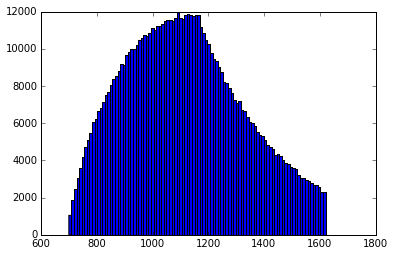

In [12]:
plt.hist(sig.cydet.data[sig.cydet.time_name], bins=100)
show()

## Prepare the data

In [13]:
import pandas
from tracking import HoughSpace
from scipy import sparse
from sklearn.metrics import roc_auc_score, roc_curve

In [14]:
hits_cydet = CyDetHits('../data/151208_SimChen_noise.root', signal_coding=[1], 
                       branches=these_branches)
hits_cth = CTHHits('../data/151208_SimChen_noise.root', signal_coding=[1])
hits = CDCHits(hits_cydet, hits_cth)

In [15]:
hits_cydet.all_branches

['CdcCell_hittype',
 'CdcCell_nHits',
 'CdcCell_hits_index',
 'CdcCell_event_index',
 'CdcCell_vol_id',
 'CdcCell_edep',
 'CdcCell_tstart',
 'CdcCell_mt']

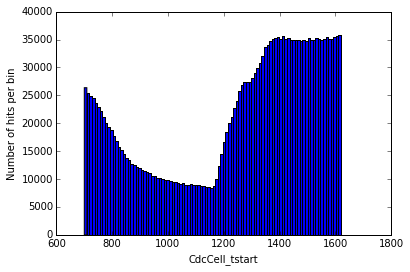

In [16]:
this_feat = "CdcCell_tstart"
plt.ylabel("Number of hits per bin")
plt.xlabel(this_feat)
plt.hist(hits_cydet.get_background_hits()[this_feat], bins=100)
plt.show()

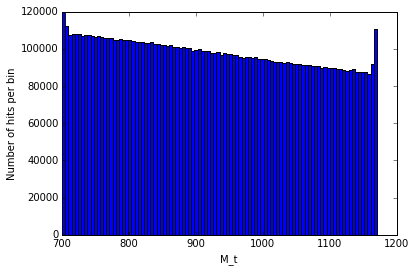

In [17]:
this_feat = "M_t"
plt.ylabel("Number of hits per bin")
plt.xlabel(this_feat)
plt.hist(hits_cth.get_background_hits()[this_feat], bins=100)
plt.show()

In [18]:
print max((hits_cth.get_background_hits()[this_feat]))

1169.99997062


In [19]:
n_events = min(sig.n_events, hits.n_events)
    
hits.trim_events(range(n_events))
sig.trim_events(range(n_events))

In [20]:
if timing_cut:
    # Apply the timing filter
    print "CTH Hits: {}".format(hits.cth.n_hits)
    print "CyDet Hits: {}".format(hits.cydet.n_hits)
    hits.cth.trim_hits(variable=hits.cth.time_name, less_than=1170, greater_than=700)
    hits.cydet.trim_hits(variable=hits.cydet.time_name, less_than=1620, greater_than=700)
    print "CTH Hits: {}".format(hits.cth.n_hits)
    print "CyDet Hits: {}".format(hits.cydet.n_hits)

CTH Hits: 9816474
CyDet Hits: 2181683
CTH Hits: 9816474
CyDet Hits: 2181683


### Set the trigger time

In [21]:
# Set the trigger times
trig_time_evt = []
for evt in range(sig.n_events):
    sig_hits = sig.cth.get_signal_hits(evt)
    if len(sig_hits) != 0:
        # Define the trigger time as the earliest signal hit in the CTH
        this_trig_time = sig_hits[sig.cth.time_name][0]
        # Record this trigger time
        trig_time_evt.append(this_trig_time)
        # Set this trigger time for both signal and background sample
        sig.cydet.data[sig.cydet.trig_name][sig.cydet.event_to_hits[evt]] = this_trig_time
        hits.cydet.data[hits.cydet.trig_name][hits.cydet.event_to_hits[evt]] = this_trig_time

(array([ 730.,  700.,  645.,  638.,  611.,  536.,  510.,  513.,  461.,  406.]),
 array([  700.01885959,   747.01603201,   794.01320444,   841.01037686,
          888.00754929,   935.00472171,   982.00189414,  1028.99906657,
         1075.99623899,  1122.99341142,  1169.99058384]),
 <a list of 10 Patch objects>)

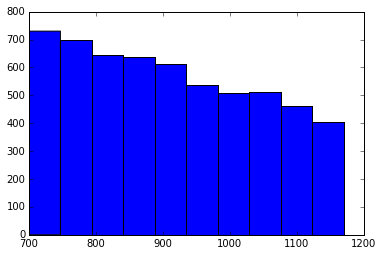

In [22]:
plt.hist(trig_time_evt)

In [23]:
right_neighs = numpy.array([hits.cydet.geom.shift_wire(wire, 1) for wire in range(hits.cydet.geom.n_points)])
left_neighs = numpy.array([hits.cydet.geom.shift_wire(wire, -1) for wire in range(hits.cydet.geom.n_points)])

In [24]:
# Energy deposits
deposits = numpy.vstack(hits.cydet.get_energy_deposits(i) \
                        + sig.cydet.get_energy_deposits(i) \
                        for i in range(n_events))
deposits *= 100 # to avoid small numbers for GBRT

In [25]:
# Figure out coincidence
sig_time =  numpy.vstack(sig.cydet.get_hit_time(i)  for i in range(n_events)) # + 700.
hit_time =  numpy.vstack(hits.cydet.get_hit_time(i) for i in range(n_events))
# Flatten at first
sig_time = sig_time.flatten()
hit_time = hit_time.flatten()
# Find signal hits
sig_mask = sig_time != 0
# Find background hits
hit_mask = hit_time != 0
# Find coincidence
both = np.logical_and(sig_mask, hit_mask)
# Find when coincidence meant signal was sooner
sig_sooner = sig_time < hit_time
# Create masks for coincidence 
both_take_sig = np.logical_and(both, sig_sooner)
both_take_hit = np.logical_and(both, np.logical_not(sig_sooner))

In [26]:
print memory_usage()
del sig_time, hit_time
print memory_usage()

[4038.015625]
[3841.39453125]


In [27]:
# Time after triggering that signal waveforms starts
sig_rel_time =  numpy.vstack(sig.cydet.get_relative_time(i)  for i in range(n_events))
hit_rel_time =  numpy.vstack(hits.cydet.get_relative_time(i) for i in range(n_events))
# Flatten at first
sig_rel_time = sig_rel_time.flatten()
hit_rel_time = hit_rel_time.flatten()
# Start with signal hit values, with the rest empty
rel_time = sig_rel_time + hit_rel_time
# Overlay masked background hits, where earlier signal hits are removed by mask
rel_time[both_take_sig] = sig_rel_time[both_take_sig]
rel_time[both_take_hit] = hit_rel_time[both_take_hit]
# Reshape back
rel_time = rel_time.reshape((n_events,-1))

In [28]:
print memory_usage()
del sig_rel_time, hit_rel_time
print memory_usage()

[4038.015625]
[3841.39453125]


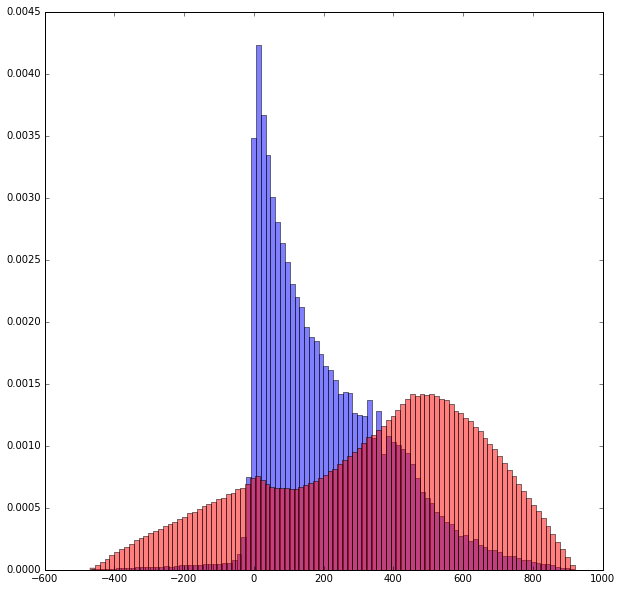

436222
2181683


In [29]:
figsize(10,10)
plt.hist(rel_time.flatten()[sig_mask], bins=100,  color='blue', alpha=0.5, normed=True)
plt.hist(rel_time.flatten()[hit_mask], bins=100,  color='red', alpha=0.5, normed=True)
show()
print len((rel_time.flatten()[sig_mask]))
print len((rel_time.flatten()[hit_mask]))

In [30]:
# Truth Values
sig_labels = numpy.vstack(sig.cydet.get_hit_types(i) for i in range(n_events))
hit_labels = numpy.vstack(hits.cydet.get_hit_types(i) for i in range(n_events)) 
# Flatten at first
sig_labels = sig_labels.flatten()
hit_labels = hit_labels.flatten()
# Define the overall relative time
labels =  hit_labels + sig_labels
# Factor in signal (and coincidence)
labels[both_take_sig] = sig_labels[both_take_sig]
labels[both_take_hit] = hit_labels[both_take_hit]
# Reshape bacl
labels = labels.reshape((n_events,-1))

In [31]:
# Layer ID of hit wires
layer_id = numpy.vstack(geom.point_rhos for i in range(n_events))

In [32]:
labels.shape, deposits.shape

((5750, 4482), (5750, 4482))

In [33]:
## Look up table to map from events to hits
event_to_hit_look = np.arange(n_events*geom.n_points).reshape(n_events, -1)

In [34]:
from sklearn.cross_validation import train_test_split
rest, sample_3 = train_test_split(range(len(labels)), train_size=0.6, test_size=0.3)
sample_1, sample_2 = train_test_split(rest, train_size=0.5, test_size=0.5)

In [35]:
print memory_usage()
del sig, hits, sig_cydet, sig_cth, hits_cydet, hits_cth
print memory_usage()

[4627.89453125]
[3551.98046875]


In [36]:
data_1, data_2, data_3 = pandas.DataFrame(), pandas.DataFrame(), pandas.DataFrame()

for data_samp, samp in zip([data_1, data_2, data_3],\
                           [sample_1, sample_2, sample_3]):
    # Deposit features
    data_samp['deposit'] = (deposits * 100)[samp].flatten()
    data_samp['r_deposit'] = (deposits * 100)[:, right_neighs][samp].flatten()
    data_samp['l_deposit'] = (deposits * 100)[:, left_neighs][samp].flatten()
    data_samp['layer_id'] = layer_id[samp].flatten()

In [37]:
print memory_usage()
del deposits, layer_id
print memory_usage()

[3552.1640625]
[3355.546875]


In [38]:
for data_samp, samp in zip([data_1, data_2, data_3],\
                           [sample_1, sample_2, sample_3]):
    # Time feature
    data_samp['rel_time'] = rel_time[samp].flatten()
    data_samp['r_rel_time'] = rel_time[:, right_neighs][samp].flatten()
    data_samp['l_rel_time'] = rel_time[:, left_neighs][samp].flatten()

In [39]:
print memory_usage()
del rel_time
print memory_usage()

[3473.52734375]
[3473.52734375]


In [40]:
for data_samp, samp in zip([data_1, data_2, data_3],\
                           [sample_1, sample_2, sample_3]):
    # Truth values
    data_samp['labels'] = labels[samp].flatten()
    data_samp['is_signal'] =  numpy.take([0, 1, 0], labels.astype(int))[samp].flatten()

In [41]:
print memory_usage()
del labels
print memory_usage()

[3650.4921875]
[3453.87109375]


In [42]:
print list(data_1.columns.astype(str))

['deposit', 'r_deposit', 'l_deposit', 'layer_id', 'rel_time', 'r_rel_time', 'l_rel_time', 'labels', 'is_signal']


In [43]:
# Define Data
train_features = list(data_1.columns[:-2])
n_feats = len(data_1.columns)
feature_labels = list(data_1.columns)

## Classify Data

In [44]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier, TMVAClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc

In [45]:
factory = ClassifiersFactory()

# Define GBDT over neighbour-level features
neigh_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                                    features=train_features)
# Add the GBDT
factory.add_classifier('Local and Neighbour Features', neigh_gbdt)

In [46]:
# Train the classifier
factory.fit(mask(data_1), mask(data_1)['is_signal'])
pass

model Local and Neighbour Features was trained in 225.56 seconds
Totally spent 225.56 seconds on training


In [47]:
print memory_usage()
del data_1
print memory_usage()

[3989.3515625]
[3458.47265625]


In [48]:
# Print these predictions
# TODO clean up pred_2, pred_evt_2
pred_2, pred_evt_2 = predict_classifier(neigh_gbdt, data_2, geometry=geom)

In [49]:
# Define which wires we want to correct as hits which were missclassified 
problem_weights_2 = (mask(data_2)['labels'] != 0) * abs(mask(data_2)['is_signal'] - pred_2) ** 2

In [50]:
print roc_auc_score(mask(data_2)['is_signal'], pred_2)
print roc_auc_score(mask(data_2)['is_signal'], pred_2, sample_weight=problem_weights_2)

0.990853015712
0.182875385695


In [51]:
from tracking import HoughSpace

default = [[31.5, 34, 34.5, 2]]
submatrices = []

# Define even and odd layer wires
even_wires = geom.point_pol != 1
odd_wires = geom.point_pol == 1

# TODO test with several radii
for rmin, rmean, rmax, rsgma in default: #[[30, 33, 35], [26, 29, 32]]:
    # Try with default values
    hough = HoughSpace(geom, sig_rho_min=rmin, sig_rho=rmean, sig_rho_max=rmax,\
                       sig_rho_sgma=rsgma, rho_bins=20, arc_bins=81)
    corresp = hough.correspondence
    submatrices.append(corresp)

# Stack all submatricies horizontally
new_correspondence = sparse.hstack(submatrices)

In [52]:
from tracking import HoughTransformer, HoughShifter
# Fit and transform the second data sample
hough_transformer = HoughTransformer(new_correspondence, \
                                     hough.norm_track_neighs,\
                                     pred_evt_2, alpha_max=2., alpha_rw=2.)

In [53]:
# Predict for third sample
pred_3, pred_evt_3 = predict_classifier(neigh_gbdt, data_3, geometry=geom)

# Get the hough results
# TODO clean up pred_2, pred_evt_2
hough_result_2, hough_image_2 = hough_transformer.transform(pred_evt_2)
hough_result_3, hough_image_3 = hough_transformer.transform(pred_evt_3)

In [54]:
# Do the first transform to get the hough space that needs to be aligned
aligner = HoughTransformer(new_correspondence, hough.norm_track_neighs, pred_evt_2, alpha_rw=2., alpha_max=2.)
_ , to_align_3 = aligner.transform(pred_evt_3)

In [55]:
# Shift this hough space to get the even and odd layers agreeing
hough_shifter_2 = HoughShifter(hough, 10, -10)
hough_shifter_3 = HoughShifter(hough, 10, -10)

# Get the images
hough_image_even_3 = to_align_3[:,:hough.track.n_points]
hough_image_odd_3 = to_align_3[:,hough.track.n_points:]
# Fit the shifter
ideal_rotate_3, integral_even_3, integral_odd_3 =\
    hough_shifter_3.fit_shift(hough_image_even_3, hough_image_odd_3)
# Shift the result
shift_pred_evt_3 = hough_shifter_3.shift_result(pred_evt_3)
shift_labels_3 = hough_shifter_3.shift_result(data_3['labels'].reshape(-1, geom.n_points))

In [56]:
# Add these as features
data_2['Hough'] = hough_result_2.flatten()
data_3['Hough'] = hough_result_3.flatten()

In [57]:
# Add this to the feature list
train_features_full = train_features + ['Hough']

# Define the new classifier
hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), 
                               features=train_features_full) 

# Define GBDT over only energy deposit to compare
dep_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=200), 
                               features=['deposit'])

# Ensure neigh-level GBDT has enough trees to compare properly
neigh_gbdt.set_params(n_estimators=200)

# Add the classifiers
factory.add_classifier('Hough, Local and Neighbour Features', hough_gbdt)
factory.add_classifier('Energy Deposition', dep_gbdt)

In [58]:
# Train the classifier
factory.fit(mask(data_2), mask(data_2)['is_signal'])
pass

model Local and Neighbour Features was trained in 425.27 seconds
model Hough, Local and Neighbour Features was trained in 231.05 seconds
model Energy Deposition was trained in 156.84 seconds
Totally spent 813.16 seconds on training


In [59]:
# Test it on the last set of data
pred_final_diag_3 = factory.test_on(mask(data_3), mask(data_3)['is_signal'])
pred_final_3, pred_final_evt_3 = predict_classifier(hough_gbdt, data_3, geometry=geom)
pred_3, pred_evt_3 = predict_classifier(neigh_gbdt, data_3, geometry=geom)

In [60]:
# TODO clean this up
from collections import OrderedDict

figsize(6.4,6.4) 
feat_label_dict = OrderedDict([
            ('l_rel_time' , "Left Timing"),  
            ('r_rel_time' , "Right Timing"),
            ("layer_id" , "R Distance"), 
            ('r_deposit' , 'Right Energy'), 
            ('l_deposit' , 'Left Energy'), 
            ('rel_time' , "Timing"),
            ('deposit' , 'Energy'), 
            ('Hough' , r"Hough, $W_j''$")
    ])

def plot_feature_importance(rep_classifier, feat_label_dict):
    feat_import = rep_classifier.get_feature_importances()
    feat_import = feat_import.sort("effect", ascending=False)
    ax = plt.subplot(111)
    ax.bar( np.arange(len(feat_import.values)), feat_import.values,zorder=10)
    ax.set_xticks(np.arange(len(feat_import.values))+0.5)
    ax.minorticks_on()
    ax.set_ylabel("Normalized Relative Usage")
    ax.set_title("Feature Importance")
    ax.autoscale()
    ax.grid(b=True, which='major', axis='y' ,color='grey', linestyle='--')
    ax.grid(b=True, which='minor', axis='y' , color='grey', linestyle=':')
    ordered_labels = OrderedDict((key, feat_label_dict[key]) for key in feat_import.index.values)
    ax.set_xticklabels(ordered_labels.values(),  rotation='vertical')
    ax.set_yticklabels(["{:.0f}%".format(tick*100) for tick in ax.get_yticks()])
    return ax

def plot_feature_correlations(rep_factory, feat_label_dict):
    corr = pred_final_diag_3.features_correlation_matrix(features=train_features+["Hough"],
                                tick_labels=[feat_label_dict[key] for key in train_features_full])
    corr.fontsize = 15
    corr.cmap = "RdBu"
    return corr.plot()

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


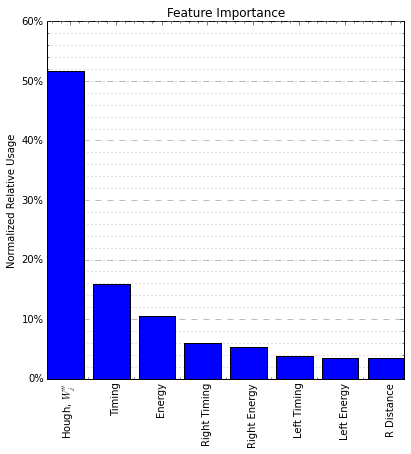

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


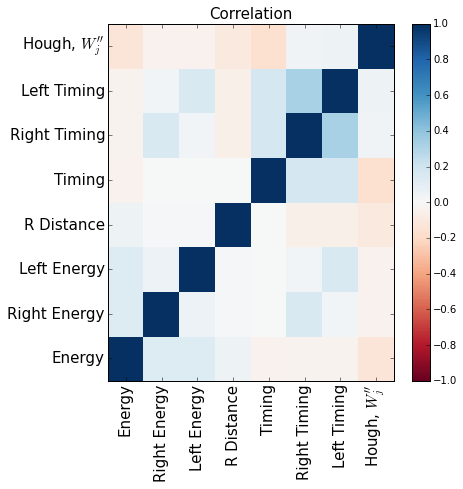

In [61]:
hough_level = factory["Hough, Local and Neighbour Features"]
plot_feature_importance(hough_level, feat_label_dict)
show()
plot_feature_correlations(factory, feat_label_dict)
show()

(<matplotlib.axes._subplots.AxesSubplot at 0x818ad610>,
 <matplotlib.figure.Figure at 0xd35bad0>)

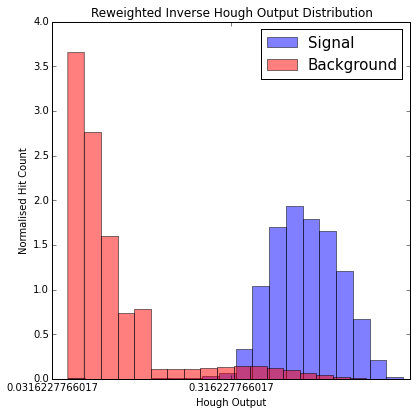

In [62]:
plot_feature( (data_3['Hough'].values+0.1), data_3['labels'].values, 
             xlabel="Hough Output", ylabel="Normalised Hit Count", xlog=True,
            title="Reweighted Inverse Hough Output Distribution", nbins=20)

In [63]:
print roc_auc_score(mask(data_3)['is_signal'], pred_final_3)

0.997314056192


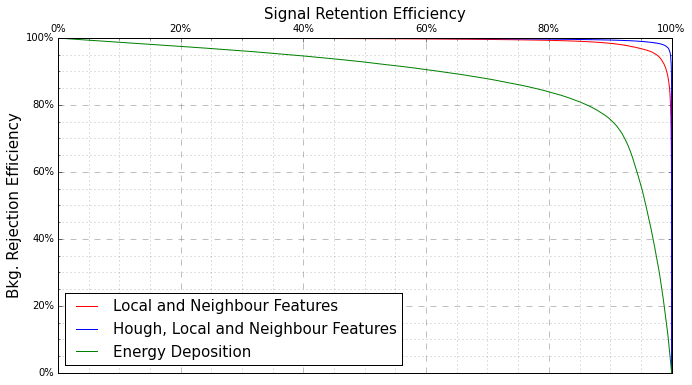

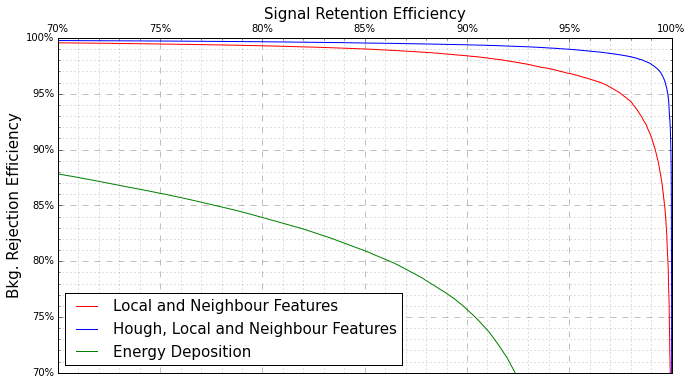

In [64]:
figsize(11,6) 
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=False)
#plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc.png", bbox_inches="tight")
show()
plot_rocs(mask(data_3)["is_signal"], pred_final_diag_3.prediction, zoom=True)
#plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/tmva_roc_zoom.png", bbox_inches="tight")
show()

/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


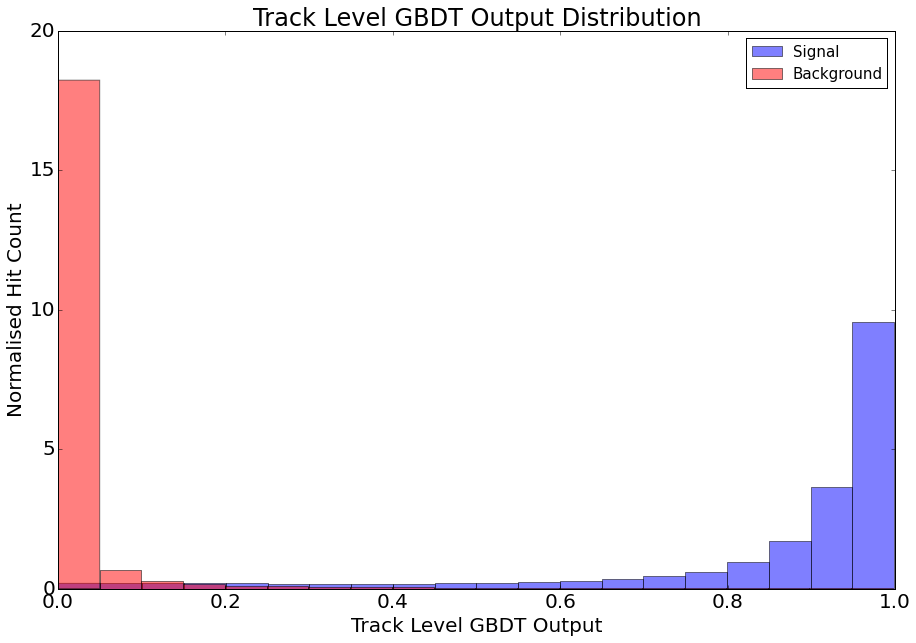

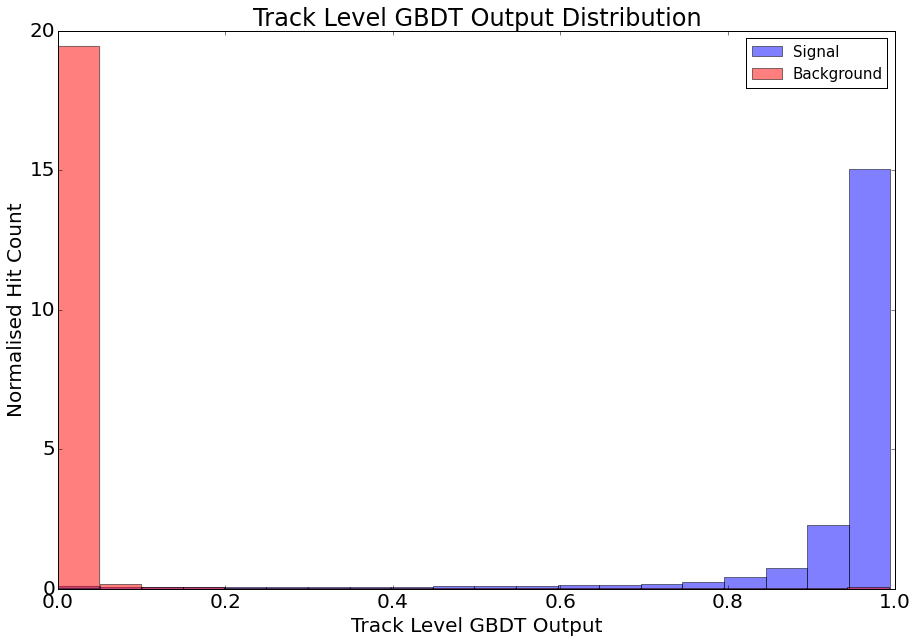

In [65]:
figsize(15,10)
plot_set_font(size=20)
plot_feature( pred_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count", 
            title="Track Level GBDT Output Distribution", nbins=20)
show()
plot_feature( pred_final_3, mask(data_3)['labels'].values, 
             xlabel="Track Level GBDT Output", ylabel="Normalised Hit Count",
            title="Track Level GBDT Output Distribution", nbins=20)
show()

In [66]:
problem_weights_3 = (mask(data_3)['labels'] != 0) * abs(mask(data_3)['is_signal'] - pred_3) ** 2
print roc_auc_score(mask(data_3)['is_signal'], pred_3)
print roc_auc_score(mask(data_3)['is_signal'], pred_3, sample_weight=problem_weights_3)

0.99282620879
0.147295106303


In [71]:
# Event information\
event = 1000
add_trans = True
save = False
savedir = "/vols/comet00/users/elg112/ICEDUST/track-finding-yandex/sakamoto_example/"

evt_hits = event_to_hit_look[event]
to_plot = data_3["labels"].values[evt_hits]
hough_output = data_3["Hough"].values[evt_hits]
plot_hough_image_3 = hough_image_3[event,:hough.track.n_points] + hough_image_3[event,hough.track.n_points:]

# Shifted plot information
shift_plot = shift_labels_3[event]

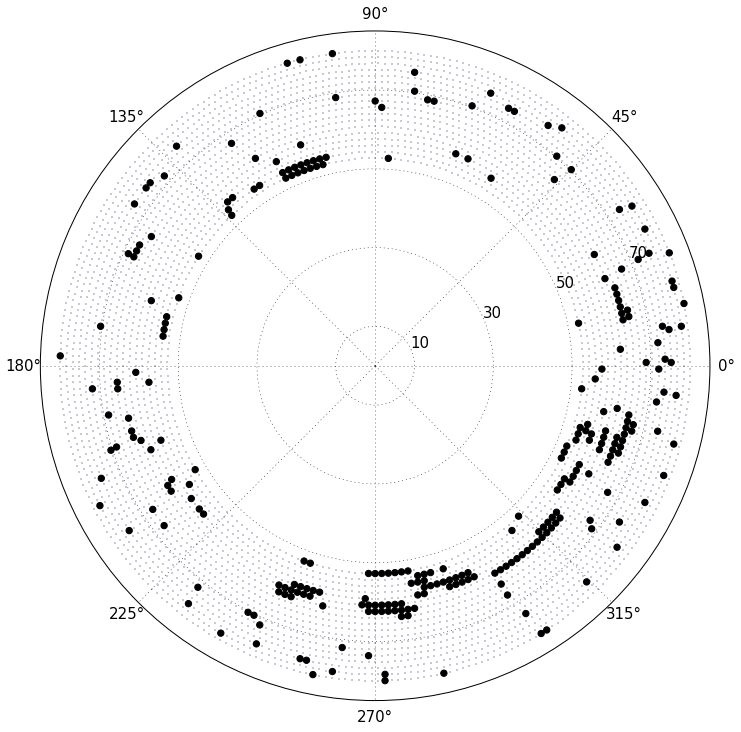

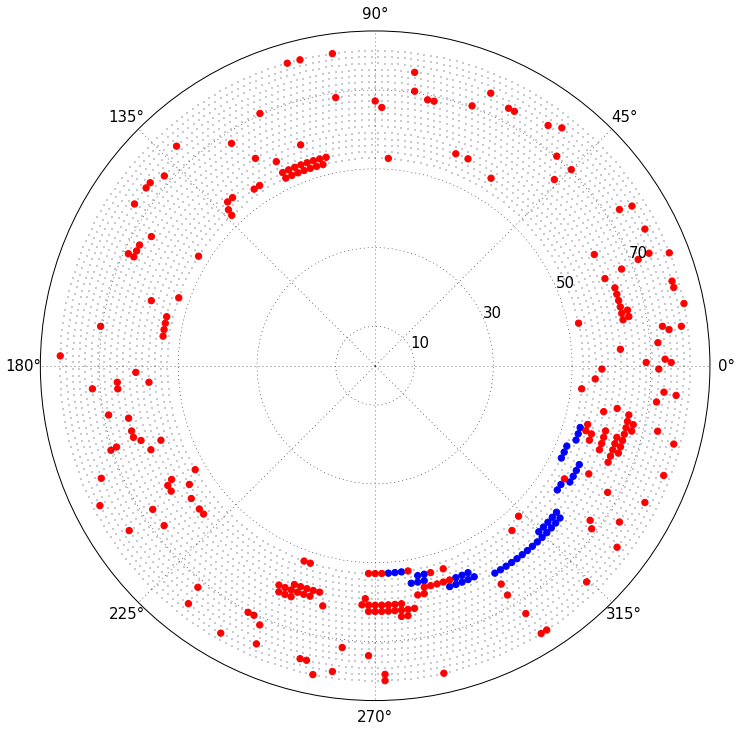

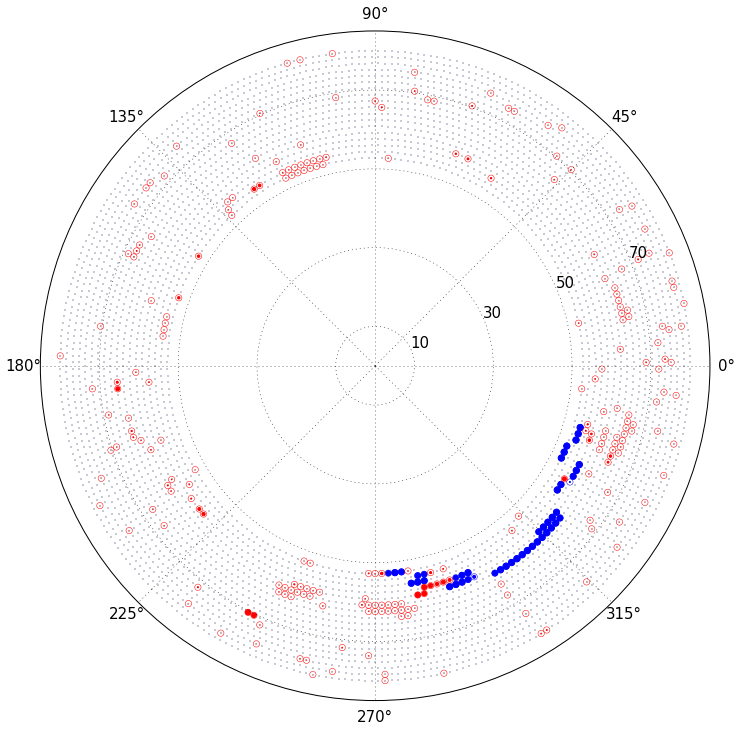

Length of draw tracks are 62


/home/hep/elg112/software/python/virtual_envs/rep/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


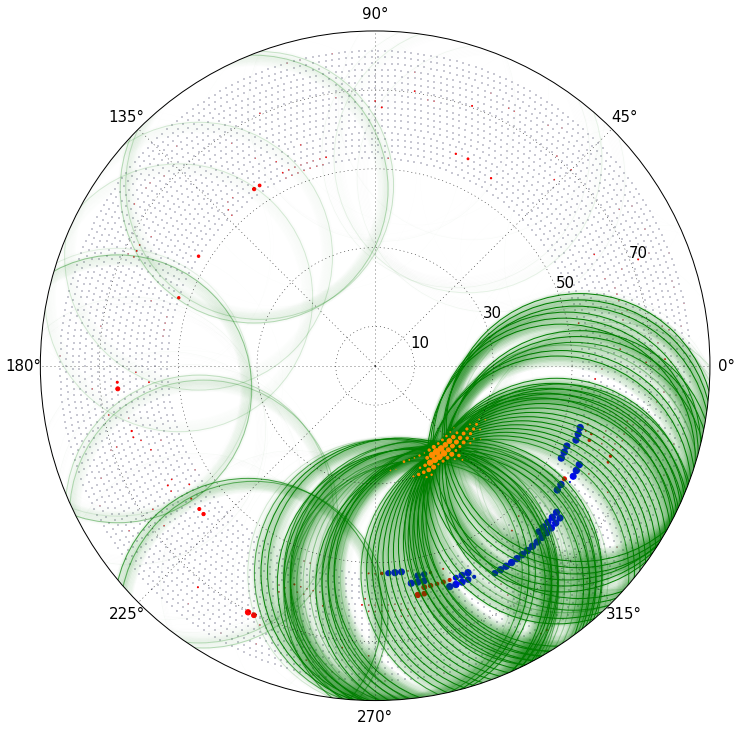

Length of draw tracks are 65


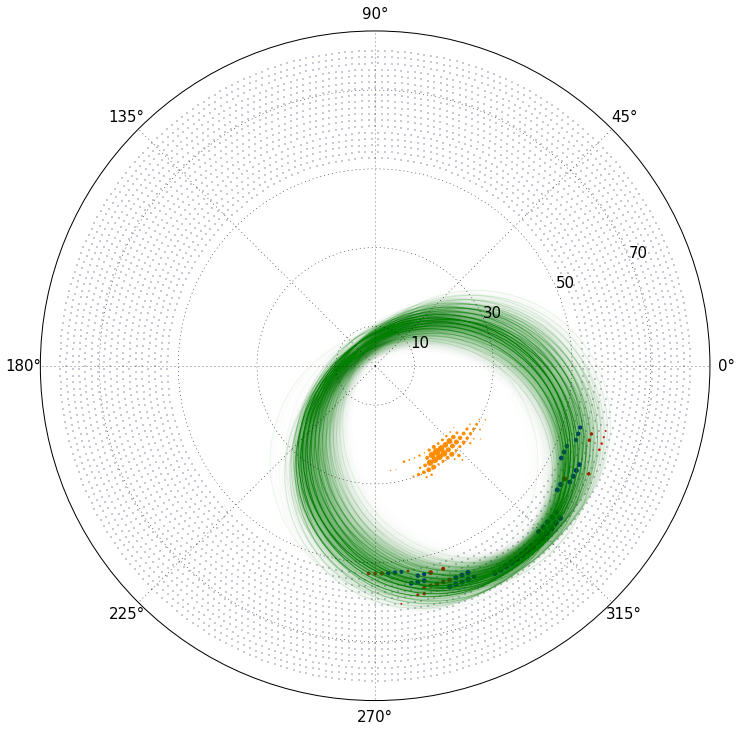

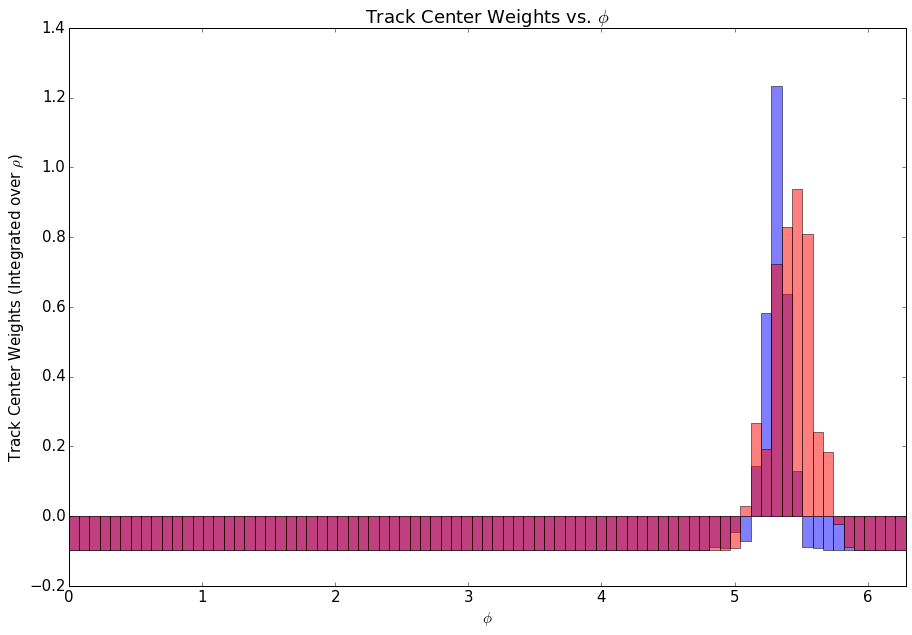

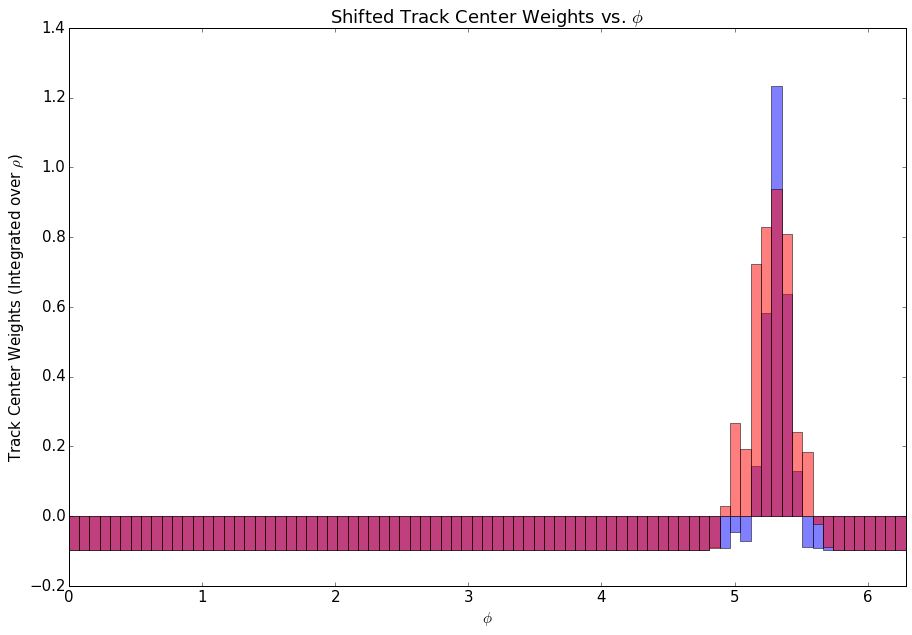

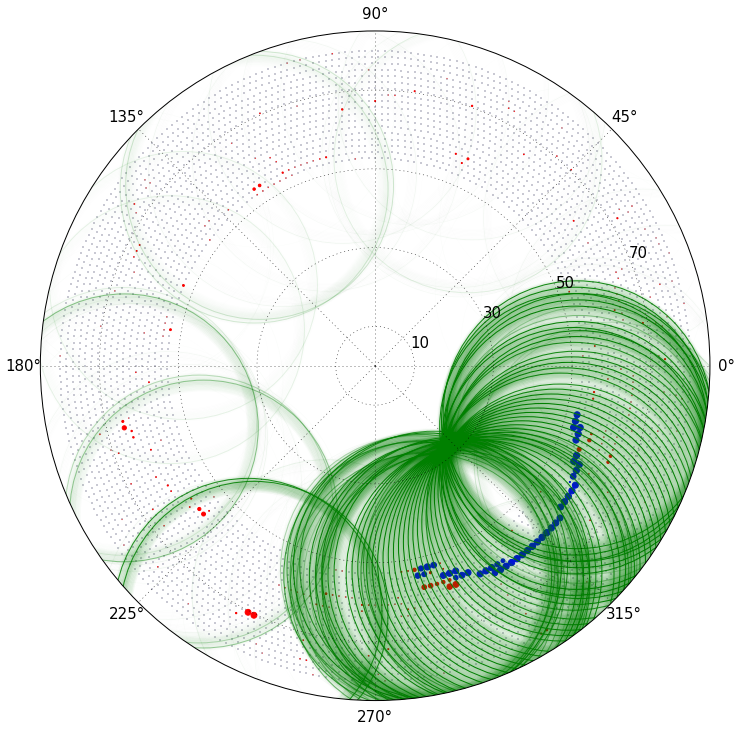

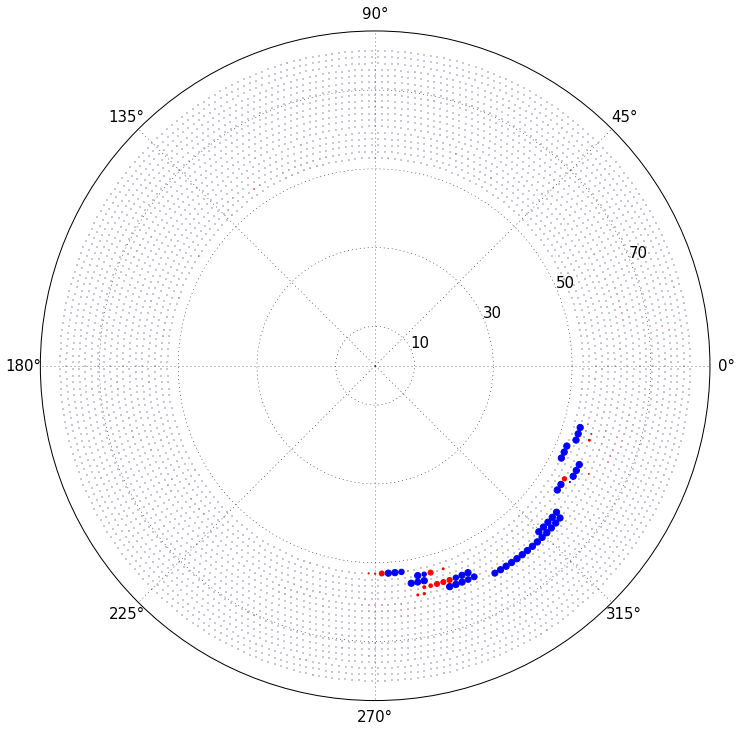

In [72]:
# Basic output
plot_output(to_plot, geom, sig_color='black', bkg_color='black', )
if save:
    plt.savefig(savedir+"plot_event_bw.png", bbox_inches='tight')
show()

plot_output(to_plot, geom)
if save:
    plt.savefig(savedir+"plot_event.png", bbox_inches='tight')
show()

# First GBDT output
plot_output(to_plot, geom, size=plot_norm_size(pred_evt_3[event,:]))
plot_add_outlines(to_plot, geom)
if save:
    plt.savefig(savedir+"plot_neigh_level.png", bbox_inches='tight')
show()

# Hough output
plot_output(to_plot, geom, size=plot_norm_size(pred_evt_3[event,:]), add_transform=add_trans)
plot_add_tracks(geom, hough, size=plot_norm_size(plot_hough_image_3,40))
if save:
    plt.savefig(savedir+"plot_hough.png", bbox_inches='tight')
show()

# Inverse Hough output
plot_output(to_plot, geom, size=plot_norm_size(hough_output))
plot_add_tracks(geom, hough, size=plot_norm_size(plot_hough_image_3,40), add_transform=add_trans,
                tolerance=0.00)
if save:
    plt.savefig(savedir+"plot_inv_hough.png", bbox_inches='tight')
show()    

# Shift in Hough Space
# TODO magic number here
plot_hough_shift(integral_even_3[event,:], integral_odd_3[event,:], 
                 hough_shifter_3.rotate_index[event]+hough_shifter_3.lower_lim)
show()

# Hough output
plot_output(shift_plot, geom, size=plot_norm_size(shift_pred_evt_3[event,:]), add_transform=add_trans)
#plot_add_tracks(geom, hough, size=plot_norm_size(shift_hough_image,40))
if save:
    plt.savefig(savedir+"plot_shft_hough.png",  bbox_inches='tight')
show()

# Inverse Hough output
#plot_output(shift_plot, geom, size=plot_norm_size(shift_hough_output))
#plot_add_tracks(geom, hough, size=plot_norm_size(shift_hough_image,40), add_transform=add_trans,
#                tolerance=0.00)
#if save:
#    plt.savefig(savedir+"plot_shft_inv_hough.png", bbox_inches='tight')
#show()

# Final
plot_output(to_plot, geom, size=plot_norm_size(pred_final_evt_3[event,:]))
if save:
    plt.savefig(savedir+"plot_final.png", bbox_inches='tight')
show()

In [ ]:
# TODO 
# Plots for Louis

# Penalize for not being the closest point to the fit



# Belle-II literature
# multiple radii
# optimize hough to improve track purity, use RANSAC to shed background islands
# 

#TODO Offline Analysis
# WEDS clean up RANSAC implimentation
# WEDS use shifted hough in RANSAC implimentation
# THURS penalize on no hits for RANSAC
# THURS change sampling probability via GBDT score
# THURS change scoring weight by GBDT score
# FRI check results for mulitple radii, no optimization
# FRI check results for varying hit efficiencies, no optimization


# In[73]:

#TODO Online
# TUES Rebuild notebook for new sample
# TUES Integrate trigger signal in
# TUES Reevaluate the flow of the algorithm


# In[74]:

# MC PRODUCTION
# Timing in Prod. Sec.
#  Determine IO and CPU time for current jobs
#  Determine best cuts to make (most obvious ones anyway)
# ECAL hits
#  After CM18
# Cross-Check occupancy
#  Generate large enough CyDet sample and check occupancy
#  Perhaps do this locally, or atleast the merging part


# In[75]:

# NOTES
## Shifting to align image in hough space must 
#  play well with the placticity already 
#  implimented in the algorithm.  Adjust reweighting
## Try reweighting background hits close to signal hits
#  as worse when we do the track level GBDT algo.  Rid
#  background islands at RANSAC level.

